# 선형 회귀


In [2]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

In [3]:
# x는 torch.FloatTensor로 생성되며, 0부터 4까지의 값을 가지고 있다.
# unsqueeze(1) 함수를 사용하여 x의 shape을 (5,)에서 (5, 1)로 변경한다.
x = torch.FloatTensor(range(5)).unsqueeze(1)
y = 2*x+torch.rand(5,1)

In [4]:
# nn.Module을 상속받아 모델을 생성한다.
# 모델은 nn.Linear를 이용하여 선형 변환을 수행하는 단일 레이어로 구성된다.
# 입력 변수의 개수와 출력 변수의 개수는 각각 1로 설정되었다.
class LinearRegressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(1,1,bias=True) # nn.Linear(N,M,bias=True)으로 표현할 수 있다. N은 입력 변수의 개수이고, M은 출력 변수의 개수이다.

  def forward(self, x): # forward 메서드는 모델의 순전파 연산을 정의한다. 입력 변수 x를 받아 선형 변환을 수행한 뒤 결과를 반환한다.
    y = self.fc(x)

    return y

In [5]:
model = LinearRegressor()
learning_rate = 1e-3
criterion = nn.MSELoss() # MSE를 손실 함수로 사용한다.
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

In [6]:
loss_stack = []
for epoch in range(1001):
  optimizer.zero_grad() # optimizer.zero_grad()를 호출하여 변화도를 초기화한다.
  # 입력 변수 x에 대한 예측값 y_hat을 계산한 뒤, 손실 함수를 활용하여 예측값과 목표 변수 y 사이의 손실을 계산한다.
  y_hat = model(x)
  loss = criterion(y_hat, y)

  loss.backward() # 손실.backward()를 호출하여 역전파를 수행한다.
  optimizer.step() # optimizer.step()을 호출하여 매개변수를 업데이트한다.
  loss_stack.append(loss.item()) # loss_stack에는 각 에포크마다의 손실 값이 저장된다.

  if epoch%100==0:
    print(f'Epoch{epoch}:{loss.item()}')

Epoch0:48.67333221435547
Epoch100:3.3943161964416504
Epoch200:0.3408830761909485
Epoch300:0.12953197956085205
Epoch400:0.11008600890636444
Epoch500:0.10414115339517593
Epoch600:0.09962665289640427
Epoch700:0.09567134827375412
Epoch800:0.09216491878032684
Epoch900:0.08905317634344101
Epoch1000:0.0862918421626091


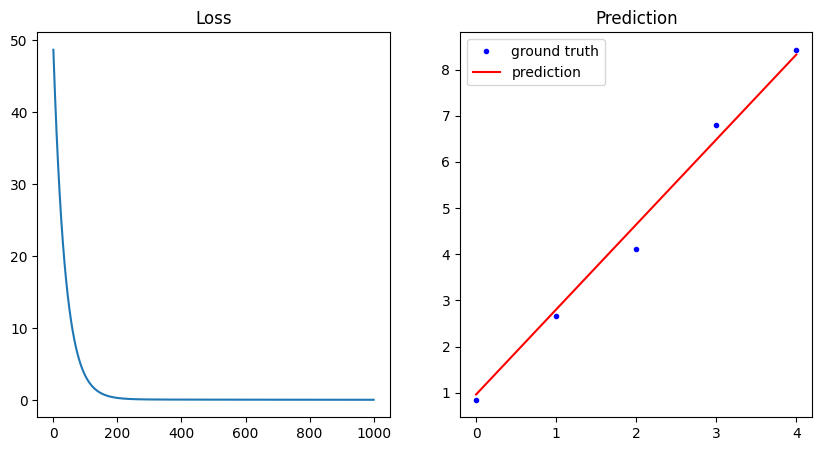

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(loss_stack)
plt.title("Loss")
plt.subplot(122)
plt.plot(x,y,'.b')
plt.plot(x.detach().numpy(), y_hat.detach().numpy(), 'r-')
plt.legend(['ground truth','prediction'])
plt.title("Prediction")
plt.show()

## 집값 예측하기
* 선형 회귀식은 nn.Linear()가 하나 있는 모델을 의미한다.
* 선혁식은 모든 데이터를 직선으로 예측하기 때문에 학습이 매우 빠르다는 장점이 있다.
* 하지만 데이터 내 변수들은 일반적으로 비선형 관계를 갖기 때문에 선형 모델을 가지고 예측하는 것은 한계가 있다.
* 따라서 nn.Linear()을 줄지어 여러 층으로 구성된 깊은 신경망을 만든다.

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

##### 데이터 세트 만들기

In [10]:
import pandas as pd

df = pd.read_csv('/data/reg.csv', index_col=[0])

##### 데이터 프레임을 넘파이 배열로 만들기

In [11]:
X = df.drop('Price', axis=1).to_numpy()
Y = df['Price'].to_numpy().reshape((-1,1))

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5) # 전체 데이터를 50:50으로 학습 데이터로 나눈다.

##### 텐서 데이터 만들기

In [13]:
class TensorData(Dataset):
  def __init__(self, x_data, y_data):
    self.x_data = torch.FloatTensor(x_data)
    self.y_data = torch.FloatTensor(y_data)
    self.len = self.y_data.shape[0]

  def __getitem__(self,index):
    return self.x_data[index], self.y_data[index]

  def __len__(self):
    return self.len

trainsets = TensorData(X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)
testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)

##### 모델 구축하기
* Regressor는 입력층 1개, 은닉층 2개, 출력층 1개를 가진 모델이다.
* 데이터 피쳐의 개수가 13이므로 입력층의 노드가 13개 있어야 하고, 하나의 값으로 표현된 집값을 예측하는 것이므로 출력층은 1개의 노드를 가져야만 한다.
* 이 모델에서는 각 은닉층마다 50, 30개의 노드를 갖도록 구축한다.*이탤릭체 텍스트*

In [15]:
class Regressor(nn.Module): # PyTorch의 nn.Module 클래스를 상속받아 구현한다.
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(13, 50, bias=True) # 이전 층의 출력값과 다음 층의 입력값의 크기는 같아야 한다.
    self.fc2 = nn.Linear(50, 30, bias=True)
    self.fc3 = nn.Linear(30, 1, bias=True)
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(F.relu(self.fc2(x)))
    # 데이터 노드가 50개인 이전 은닉층에서 30개의 은닉층으로 넘어갈 때 ReLU라는 활성호 함수를 거친다.
    # self.dropout을 이용해 30개 중 50%의 확률로 값을 0으로 만든다.
    # 드롭아웃은 과적합을 방지하기 위해 노드의 일부를 배제하고 학습하는 방식이기 때문에
    # 사용위치는 임의로 정할 수 있지만 절대로 출력층에 사용해서는 안 된다.
    x = F.relu(self.fc3(x))
    return x

##### 모델 학습하기

In [18]:
model = Regressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-7)

In [19]:
loss_ = []
n = len(trainloader)
for epoch in range(400):
  running_loss = 0.0
  for data in trainloader:
    inputs, values = data
    optimizer.zero_grad() # optimizer.zero_grad()로 기울기를 초기화한다.
    outputs = model(inputs) # model(inputs)로 예측값을 계산한다.
    loss = criterion(outputs, values) # 손실을 계산한다.
    loss.backward() # 역전파를 수행한다.
    optimizer.step() # 가중치를 업데이트한다.
    running_loss += loss.item()  # running_loss에 손실값을 누적한다.

  loss_.append(running_loss/n)

##### 손실 함수값 그리기
* 학습 데이터의 손실 함수값으로는 모델의 성능을 판단할 수 없지만, 학습이 잘 진행되었는지는 파악할 수 있다.

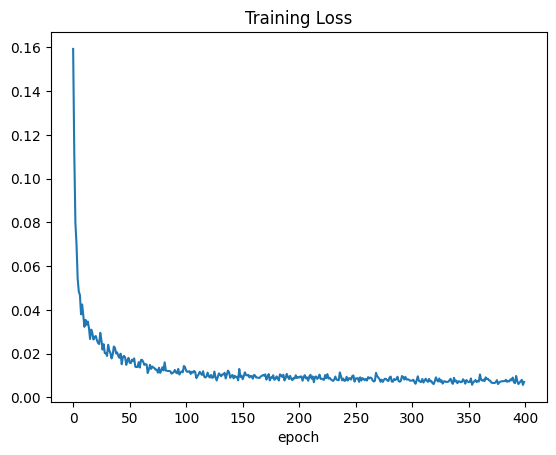

In [20]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

##### 모델 평가하기

In [21]:
def evaluation(dataloader):
  predictions = torch.tensor([],dtype=torch.float)
  actual = torch.tensor([], dtype=torch.float)
  # torch.no_grad()를 사용하여 그래디언트(gradient)를 계산하지 않도록 설정한다.
  # 이는 평가 단계에서는 모델의 가중치를 업데이트하지 않기 위한 목적이다.
  with torch.no_grad():
    model.eval()
    for data in dataloader:
      inputs, values = data
      outputs = model(inputs)
      # 예측값을 predictions 텐서에 추가한다.
      # 이 때, torch.cat() 함수를 사용하여 예측값을 기존의 predictions 텐서에 연결한다.
      predictions = torch.cat((predictions, outputs), 0)
      # 실제 값들을 actual 텐서에 추가한다.
      # 역시 torch.cat() 함수를 사용하여 실제 값들을 기존의 actual 텐서에 연결한다.
      actual = torch.cat((actual, values), 0)

  predictions = predictions.numpy()
  actual = actual.numpy()
  # mean_squared_error() 함수를 사용하여 예측값과 실제값의 평균 제곱 오차를 계산한다.
  rmse = np.sqrt(mean_squared_error(predictions, actual))

  return rmse

* 결과를 보면 학습 결과와 테스트 결과가 차이가 크다.
* 따라서 학습 데이터에 과적합이 되어 있다고 판단할 수 있다.

In [22]:
train_rmse = evaluation(trainloader) # 학습 데이터의 RMSE
test_rmse = evaluation(testloader) # 시험 데이터의 RMSE
print("Train RMSE: ", train_rmse)
print("Test RMSE: ", test_rmse)

Train RMSE:  0.062985055
Test RMSE:  0.11570426


### 활성화 함수
* 인공 신경망은 선형식 계산의 연속이다.
* 이를 통해 연산을 쉽게 할 수 있으며 미분이 가능하고 미분을 쉽게 풀 수 있게 된다.
* 활성화 함수를 사용하면, 비선형적인 층 사이의 관계를 표현할 수 있다.
* 활성화 함수는 합성 함수의 일환으로 이전 노드의 값과 가중치가 계산된 값을 활성화 함수에 넣어 계산한 뒤 다음 노드에 보낸다.
* a(x) = max(x,0)로 정의된 활성화 함수 ReLU 함수를 사용했다면 음수는 모두 0으로 나오고, 양수는 계산 그대로 넘겨주게 된다.

##### 시그모이드(sigmoid)
* 모든 입력값에 대해 0과 1 사이로 변환하는 역할을 하며 일반적으로 sigma로 표기한다.**굵은 텍스트**
* 0.5를 기준으로 0.5 이하이면 0, 초과면 1로 변환하여 두 가지 클래스를 분류하는 이진분류(binary classification)문제에도 활용할 수 있다.

##### tanh 함수
* -1과 1 사이의 값을 취할 수 있어 0과 음수값을 가질 수 있다.
* 0 부군에서 가파른 기울기를 가진다는 것이 차이점이다.

##### ReLU 함수
* 두 개의 직선을 이어 만든 것.
* 모델 최적화에 유용한 선형적 성질들을 보존하고 있어서 최적화를 쉽게 할 수 있다.
* 가장 널리 사용되며 성능이 매우 좋은 것으로 알려져 있다.

##### Softmax 함수
* 벡터 형태로 예측값이 나오는 다중 분류문제에서 자주 사용된다.
* 벡터에 대하여 모든 성분이 항상 양수이며, 그 합이 1이 되도록 변환한다.

### 손실 함수
* 손실 함수는 최적화를 하는데 목적 함수가 되기 때문에 문제에 맞는 손실 함수를 사용해야만 한다.
* MAE, MSE, Cross Entropy Loss등이 있다.

### 최적화 기법
* 인공 신경망은 예측한 값과 타깃값을 정량적으로 비교할 수 있는 손실 함수를 통해 모델을 평가할 수 있다.
* 일반적으로 손실 함수값이 작다는 의미는 예측값과 타깃값의 차이가 작다라는 의미이므로 손실 함수값이 작게 나오게 하는 모델의 변수를 구하는 것이 최적화의 목적이다.
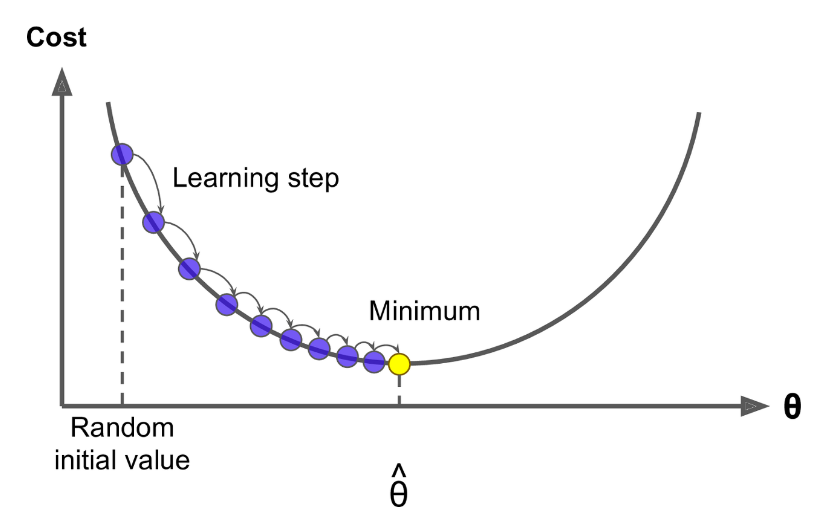

* 위 그림과 같이 손실 함수값이 가장 작게 나오게 하는 변수를 찾는 것이 목적이 되는 것이다.
* 직관적으로 경사가 떨어지는 방향으로 간다면 우리가 원하는 이상적인 값을 얻을 수 있다.
* 이를 경사하강법(Gradient Descent)라고 한다.
* 이때 하강에 대한 보폭을 정해주는 값이 학습률(learning rate)이다.
* 파이토치는 계산을 자동으로 해주는 다양한 최적화 기법들을 제공하기 때문에 최적화 기법에 대한 하이퍼 파라미터만 신경써주면 된다.
* 하이퍼 파라미터란 제안된 방법론을 사용하기 위해 미리 선택하여 사용되는 변수를 의미하며, 학습률이 하나의 예이다.

##### 확률정 경사하강법(SGD)
* 만약 n개의 데이터가 있다면 임의로 k개의 데이터 묶음을 만들어 학습을 진행한다.
* 이때 나눠진 데이터 세트를 미니 배치라고 하며, 미니 배치를 이용해 경사하강법을 진행하는 것을 확률적 경사하강법(Stocastic Gradient:SGD)라고 한다.
* "확률적"이라고 하는 이유는 미니 배치를 나눌 때 데이터를 무작위로 섞어서 나누기 때문이다.

In [23]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

##### 다양한 최적화 기법
* 경사하강법과 SGD의 단점은 학습률이 고정되어 있다는 것이다.
* 더 효육적인 최적화를 위해 여러가지 방법들이 고안되었고, 그중 기본적으로 많이 사용되는 방법은 모멘텀+스케줄링이나 Adam이다.

In [24]:
# SGD 함수에 momentum 지수를 넣어준다.
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [26]:
# Adam 방법
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### 교차 검증
* 전체 데이터를 학습, 검증, 평가 데이터로 나누어 학습 데이터로 모델을 학습하고 검증 데이터로 모델을 평가하고 튜닝한 다음 평가 데이터로 최종 평가를 한다.
* 데이터를 나누는 방법은 매우 다양하다. 그 중 k겹 교차 검증(k-Fold Cross-Validation)은 학습 데이터 전체를 사용하면서 검증할 수 있는 방법으로 머신러닝 분야에서 매우 널리 쓰이는 검증 방법이다.
* 학습 데이터를 k개로 나누어 1개는 검증 데이터로 사용하고 나머지 k-1개는 학습 데이터로 사용한다.
* 따라서 k번의 검증 과정이 필요하기 때문에 느린 것이 단점이다.

##### 손실 함수의 교차 검증 정의

In [28]:
from sklearn.model_selection import KFold

# 학습 데이터를 3개의 폴드로 나눠 3겹 교차 검증을 진행한다.
kfold = KFold(n_splits=3, shuffle=True)
criterion = nn.MSELoss()

##### 교차 검증을 이용한 학습 및 평가

In [30]:
validation_loss = []

# kfold.split(trainsets)를 사용하여 학습 데이터를 폴드로 나누고,
# fold와 해당 폴드에서의 학습 인덱스 train_idx와 검증 인덱스 val_idx를 반환한다.
for fold, (train_idx, val_idx) in enumerate(kfold.split(trainsets)):
  # SubsetRandomSampler를 사용하여
  # 학습 데이터의 일부를 선택하는 train_subsampler와 검증 데이터의 일부를 선택하는 val_subsampler를 생성한다.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
  val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
  # torch.utils.data.DataLoader를 사용하여 학습 데이터와 검증 데이터를 미니배치 단위로 나누고,
  # 각각 trainloader와 valloader로 저장합니다. batch_size는 32로 설정되어 있다.
  trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, sampler=train_subsampler)
  valloader = torch.utils.data.DataLoader(trainsets, batch_size=32, sampler=val_subsampler)

  model=Regressor()
  # optim.Adam을 사용하여 모델의 매개변수를 최적화하는 optimizer를 정의한다.
  # 학습률은 0.001이며, 가중치 감소(weight decay)는 1e-7로 설정되어 있다.
  optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

  for epoch in range(400):
    for data in trainloader:
      inputs, values = data
      # optimizer.zero_grad()를 호출하여 기울기를 초기화한다.
      optimizer.zero_grad()

      outputs = model(inputs)
      # 손실 함수를 사용하여 출력값과 실제 값 사이의 손실을 계산한다.
      loss = criterion(outputs, values)
      # 역전파를 수행한다.
      loss.backward()
      # 매개변수를 업데이트한다.
      optimizer.step()

  train_rmse = evaluation(trainloader)
  # 검증 데이터에 대한 RMSE를 계산하여 val_rmse에 저장한다.
  # 역시 evaluation 함수를 사용한다.
  val_rmse = evaluation(valloader)
  print("k-fold", fold, " Train Loss: %.4f, Validation Loss: %.4f" %(train_rmse, val_rmse))
  validation_loss.append(val_rmse)

k-fold 0  Train Loss: 0.0684, Validation Loss: 0.1202
k-fold 1  Train Loss: 0.0623, Validation Loss: 0.1433
k-fold 2  Train Loss: 0.0687, Validation Loss: 0.0982


##### 검증 점수 산출

In [32]:
validation_loss = np.array(validation_loss)
mean = np.mean(validation_loss)
std = np.std(validation_loss)
print("Validation Score: %.4f, +-%.4f" %(mean, std))

Validation Score: 0.1205, +-0.0184


##### 모델 평가

In [34]:
trianloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=False)
train_rmse = evaluation(trainloader)
test_rmse = evaluation(testloader)
print("Train RMSE: %.4f" %train_rmse)
print("Test RMSE: %.4f" %test_rmse)

Train RMSE: 0.0687
Test RMSE: 0.1194
